This notebook implements the experiment from the paper **AI safety via debate** by *Irving, Christiano and Amodei*: https://arxiv.org/abs/1805.00899

In this experiment, there is a judge, which is a CNN that has been trained to classify MNIST images given 6 non-zero pixels, to about 60% accuracy.
The debate augments the capability of the judge by having 2 agents, one honest and the other dishonest, attempt to convince the judge of their claim by successively choosing a pixel, up to 3 each, that gives them the best chance at winning, by running a Monte Carlo tree search. This boosts the accuracy of the judge to around 90%.

First, the judge is trained using the architecture described here (the link in the paper now redirects to a different page): https://github.com/tensorflow/docs/blob/master/site/en/r1/tutorials/estimators/cnn.ipynb


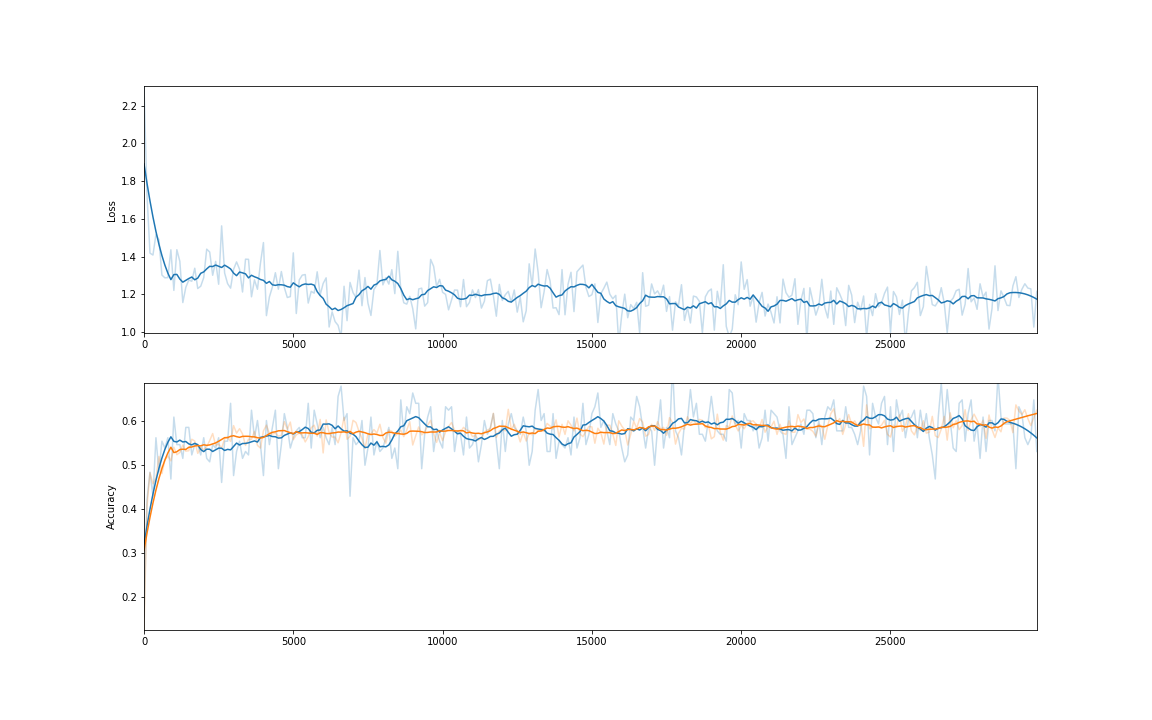

In [ ]:
%matplotlib notebook

from logger import Plotter
import random
import torch
from torch import nn
from torch.utils import data
from torchvision import datasets, transforms

MASK_SIZE = 6
BATCH_SIZE = 128
N_BATCHES = 30000

plotter = Plotter('Loss', 'Accuracy')

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# load data
transform = transforms.Compose([transforms.ToTensor(), transforms.Lambda(lambda t: t.to(device))])
mnist = datasets.MNIST('datasets', download=True, transform=transform)
mnist_loader = data.DataLoader(mnist,
                               batch_size=BATCH_SIZE,
                               sampler=data.RandomSampler(mnist, replacement=True, num_samples=BATCH_SIZE*N_BATCHES))

mnist_validation = datasets.MNIST('datasets', train=False, transform=)
mnist_validation_loader = data.DataLoader(mnist_validation,
                                          batch_size=1000,
                                          sampler=data.RandomSampler(mnist_validation, replacement=True, num_samples=1000))

# initialise judge
judge = nn.Sequential(nn.Conv2d(2, 32, 5, padding=2),
                      nn.ReLU(),
                      nn.MaxPool2d(2),
                      nn.Conv2d(32, 64, 5, padding=2),
                      nn.ReLU(),
                      nn.MaxPool2d(2),
                      nn.Flatten(),
                      nn.Linear(7 * 7 * 64, 1024),
                      nn.ReLU(),
                      nn.Dropout(0.4),
                      nn.Linear(1024, 10)).to(device)
optimiser = torch.optim.Adam(judge.parameters(), lr=1e-4)
loss_function = nn.CrossEntropyLoss()

def mask_batch(batch):
    mask = torch.zeros_like(batch)
    mask[list(zip(*[[i] + sample for i, b in enumerate(batch) for sample in random.sample(b.nonzero().tolist(), 6)]))] = 1
    return torch.cat([mask, mask * batch], dim=1)

def get_accuracy(batch, batch_labels):
    judge.eval()
    with torch.no_grad():
        logits = judge(mask_batch(batch))
    judge.train()

    predictions = logits.argmax(dim=1)
    return sum(predictions == batch_labels).item() / len(batch)

# train judge
ep = 0
for batch, batch_labels in mnist_loader:
    batch_labels = batch_labels.to(device)
    logits = judge(mask_batch(batch))
    loss = loss_function(logits, batch_labels)
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()

    ep += 1
    if ep % 100:
        continue

    accuracy = get_accuracy(batch, batch_labels)
    for val_batch, val_batch_labels in mnist_validation_loader:
        val_accuracy = get_accuracy(val_batch, val_batch_labels.to(device))

    plotter.update(ep, loss.item(), (accuracy, val_accuracy))

torch.save(judge, 'judge.pt')

This recreates the accuracy heatmap shown in the paper.

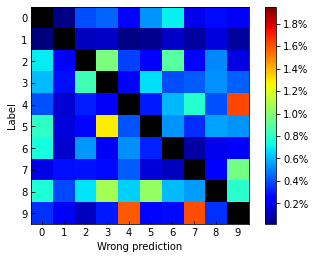

In [ ]:
%matplotlib inline

import matplotlib
from matplotlib import pyplot as plt
import random
import torch
from torch.utils import data
from torchvision import datasets, transforms

# load judge
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
judge = torch.load('judge.pt').eval().to(device)
for p in judge.parameters():
    p.requires_grad = False

# load data
transform = transforms.Compose([transforms.ToTensor(), transforms.Lambda(lambda t: t.to(device))])
mnist = datasets.MNIST('datasets', download=True, train=False, transform=transform)
mnist_loader = data.DataLoader(mnist, batch_size=len(mnist))

def mask_batch(batch):
    mask = torch.zeros_like(batch)
    mask[list(zip(*[[i] + sample for i, b in enumerate(batch) for sample in random.sample(b.nonzero().tolist(), 6)]))] = 1
    return torch.cat([mask, mask * batch], dim=1)

TRIALS = 10
results = torch.zeros(10, 10)
for batch, batch_labels in mnist_loader:
    for _ in range(TRIALS):
        batch_results = judge(mask_batch(batch)).argmax(dim=1)
        for label, result in zip(batch_labels, batch_results):
            results[label, result] += 1

jet = matplotlib.cm.get_cmap('jet')
cdict = jet._segmentdata.copy()
cdict['red'] += ((1, 0, 0),)
cdict['green'] += ((1, 0, 0),)
cdict['blue'] += ((1, 0, 0),)
jet_with_black = matplotlib.colors.LinearSegmentedColormap('Jet with black', segmentdata=cdict)

im = plt.imshow(100 * results / (TRIALS * len(mnist)), cmap=jet_with_black, vmax=1.95)
ax = im.axes

ax.tick_params(direction='in')
ax.set_xticks(range(10))
ax.set_yticks(range(10))

ax.set_xlabel('Wrong prediction')
ax.set_ylabel('Label')

ax.set_title('Judge errors for random 6 pixel masks')

plt.colorbar(im, ticks=torch.arange(0.2, 2, 0.2), format=matplotlib.ticker.PercentFormatter(decimals=1))

Finally, this simulates one debate using MCTS.
In the paper, when the dishonest agent is forced to pre-commit, they run a debate for each possible lie. Furthermore, they run each debate 3 times and take the mean result. This runs all 27 games in parallel.

In [ ]:
%matplotlib inline

import random
import torch
from torch.utils import data
from torchvision import datasets, transforms

# load judge
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
judge = torch.load('judge.pt').eval().to(device)
for p in judge.parameters():
    p.requires_grad = False

# load data
transform = transforms.Compose([transforms.ToTensor(), transforms.Lambda(lambda t: t.to(device))])
mnist = datasets.MNIST('datasets', download=True, transform=transform)
mnist_loader = data.DataLoader(mnist, batch_size=1, shuffle=True)

# MCTS
class MCTNode:
    def __init__(self, player, n_moves, moves, parent=None):
        self.player = player
        self.n_moves = n_moves
        self.moves = moves
        self.parent = parent

        self.result = None
        self.is_expanded = False

    def expand(self):
        self.is_expanded = True
        self.exploration = 10
        self.prior = 1 / self.n_moves
        self.children = [None] * self.n_moves
        self.visit_counts = torch.zeros(self.n_moves)
        self.values = torch.zeros(self.n_moves)
        return self.get_child(random.choice(range(self.n_moves)))

    def get_child(self, i):
        if self.children[i] is None:
            self.children[i] = MCTNode(-self.player, self.n_moves, self.moves + [i], self)
        return self.children[i]
    
    def best_child(self):
        return self.children[self.visit_counts.argmax().item()]

    def select_leaf(self):
        if not self.is_expanded:
            return self

        Q = self.values / (1 + self.visit_counts)
        U = self.exploration * self.prior * self.visit_counts.sum().sqrt() / (1 + self.visit_counts)
        V = self.player * (Q + U)
        return self.get_child(random.choice((V == V.max()).nonzero()).item()).select_leaf()
    
    def backup(self, result):
        if len(self.moves) == 6:
            self.result = result

        if self.parent:
            self.parent.visit_counts[self.moves[-1]] += 1
            self.parent.values[self.moves[-1]] += result
            self.parent.backup(result)

ROUNDS = 6
for image, batch_labels in mnist_loader:
    truth = batch_labels[0]
    lies = torch.tensor([n for n in range(10) if n != truth] * 3)

    pixels = image.nonzero()
    n_moves = len(pixels)
    start_player = 1 # 1 for honest start, -1 for liar start
    trees = [MCTNode(start_player, n_moves, []) for _ in lies]
    print('Starting')
    for round in range(ROUNDS):
        for _ in range(10000):
            leaves = [None] * len(lies)
            results = [None] * len(lies)
            batch_indices = []
            batch_moves = []
            for i, tree in enumerate(trees):
                # select
                leaf = leaves[i] = tree.select_leaf()
                if leaf.result is not None:
                    results[i] = leaf.result
                elif len(leaf.moves) == ROUNDS:
                    batch_indices.append(i)
                    batch_moves.append(leaf.moves)
                else:
                    # expand
                    leaf = leaves[i] = leaf.expand()
                    batch_indices.append(i)
                    batch_moves.append(leaf.moves + random.sample(range(n_moves), ROUNDS - len(leaf.moves)))

            # evaluate
            if batch_indices:
                batch_size = len(batch_indices)
                indices = torch.cat([torch.tensor(range(batch_size)).unsqueeze(1).expand(batch_size, ROUNDS).unsqueeze(2),
                                     pixels[:, 1:][torch.tensor(batch_moves)]], dim=2).T.reshape(4, -1)
                mask = torch.zeros_like(image).repeat(batch_size, 1, 1, 1)
                mask[list(indices)] = 1
                batch_logits = judge(torch.cat([mask, mask * image], dim=1))
                for i, logits in zip(batch_indices, batch_logits):
                    results[i] = 1 if logits[truth] > logits[lies[i]] else -1

            # backup
            for leaf, result in zip(leaves, results):
                leaf.backup(result)
        for i, tree in enumerate(trees):
            trees[i] = tree.best_child()
        print(f'{round+1}:', [tree.moves[-1] for tree in trees])
            
    results = torch.tensor([tree.result for tree in trees])
    for i in range(3):
        if torch.all(results[9 * i: 9 * (i + 1)] == 1):
            print(f'Game {i}: win')
        else:
            print(f'Game {i}: loss')
    break

Starting
1: [86, 114, 139, 89, 1, 248, 147, 192, 109, 134, 104, 29, 243, 56, 249, 54, 178, 248, 163, 91, 117, 56, 55, 29, 222, 106, 21]
2: [62, 26, 161, 133, 227, 187, 137, 251, 75, 43, 157, 7, 191, 142, 2, 80, 213, 188, 5, 144, 173, 171, 58, 221, 187, 95, 96]
3: [119, 87, 1, 235, 248, 124, 111, 4, 241, 189, 58, 129, 125, 91, 225, 218, 90, 110, 220, 107, 248, 219, 153, 21, 75, 74, 87]
4: [144, 230, 220, 90, 245, 7, 172, 205, 68, 123, 216, 128, 109, 83, 167, 109, 120, 170, 126, 80, 144, 176, 185, 167, 68, 168, 253]
5: [94, 12, 128, 192, 151, 85, 140, 139, 220, 120, 178, 84, 176, 2, 254, 114, 164, 149, 206, 26, 117, 12, 213, 15, 245, 183, 192]
6: [186, 15, 25, 118, 25, 94, 234, 51, 104, 147, 97, 119, 253, 131, 124, 36, 193, 72, 81, 41, 147, 98, 122, 142, 35, 178, 62]
Game 0: win
Game 1: loss
Game 2: win


This visualises the moves played in each game, with each row representing one of the three debates.

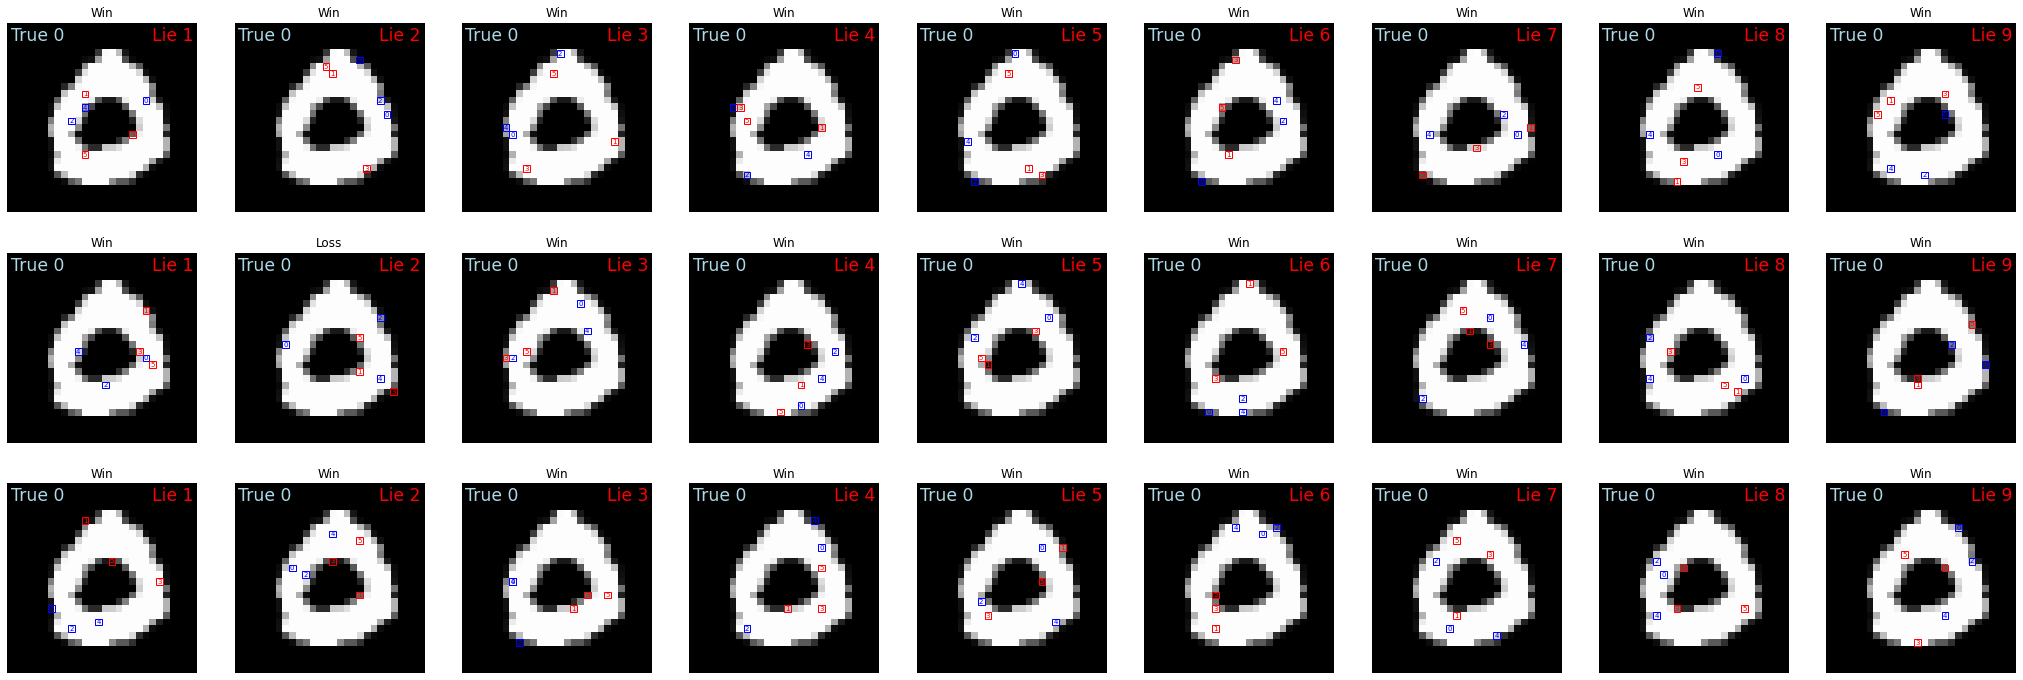

In [ ]:
from matplotlib import patches
from matplotlib import pyplot as plt

plt.rcParams['figure.figsize'] = (36, 12)

fig, axes = plt.subplots(3, 9)

for lie, tree, ax in zip(lies, trees, [ax for row in axes for ax in row]):
    ax.axis('off')
    ax.imshow(image[0][0], cmap='gray')

    ax.set_title('Win' if tree.result == 1 else 'Loss')
    ax.text(0, 0, f'True {truth}', color='lightblue', size='xx-large', va='top')
    ax.text(27, 0, f'Lie {lie}', color='r', size='xx-large', ha='right', va='top')

    for i, move in enumerate(tree.moves):
        colour = 'b' if (i + (start_player == 1)) % 2 else 'r'
        y, x = pixels[move][2:]
        ax.add_patch(patches.Rectangle((x-0.5, y-0.5), 1, 1, linewidth=1, edgecolor=colour, fill=None))
        ax.text(x, y, i, color=colour, size='x-small', ha='center', va='center')